# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [192]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import copy
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [193]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers   
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [194]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    # print(len(X_dna_seqs_train), len(X_dna_seqs_train[0]))
    
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X 
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    # use intseq_to_dnaseq here to convert ids back to DNA seqs
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train)))

    #step3
    # use count_cpgs here to generate labels with temp generated in step2
    y_dna_seqs = [count_cpgs(seq) for seq in temp]     
    return X_dna_seqs_train, y_dna_seqs
    
train_x, train_y = prepare_data(2048)
valid_x, valid_y = prepare_data(256)
test_x, test_y = prepare_data(512)

In [195]:
# Just a minor check to make sure it processed as expected
# train_x[0][:20], valid_x[0][:20], test_x[0][:20]

#### Optional EDA 

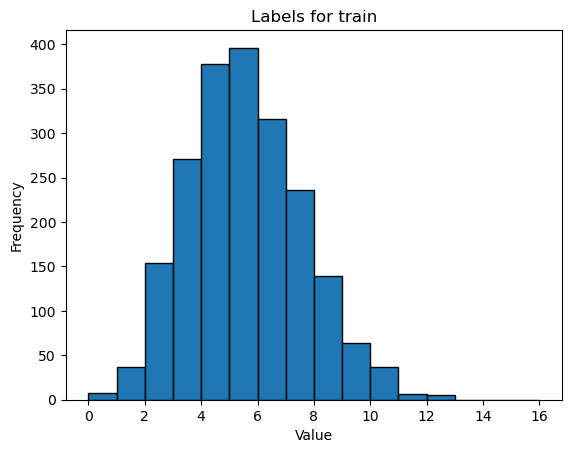

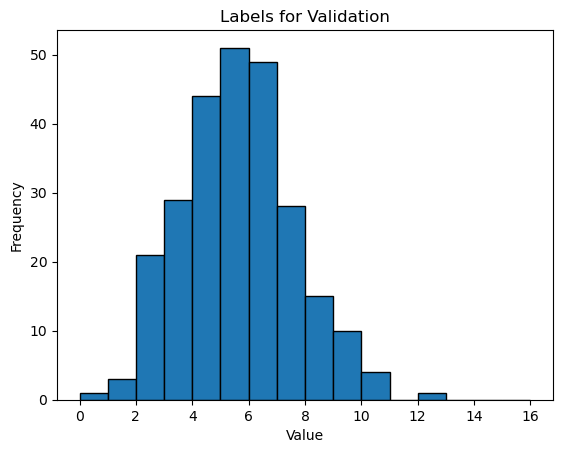

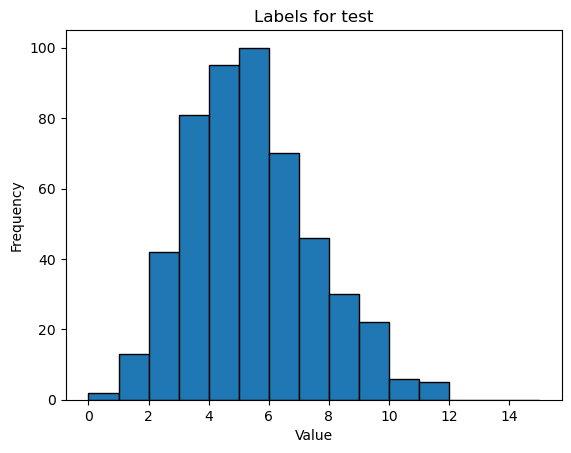

In [196]:
import matplotlib.pyplot as plt

def plot_hist(data, title):
    '''
    To plot histogram, to verify if there's a class imbalance 
    (incase we want to formulate it as a classification problem). 
    Always good to do some EDA as it won't hurt anyways whether we use or not!
    '''
    plt.hist(data, bins=range(min(data), max(data) + 5, 1), edgecolor='black')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f"{title}")
    plt.show()

plot_hist(train_y, "Labels for train")
plot_hist(valid_y, "Labels for Validation")
plot_hist(test_y, "Labels for test")

In [197]:
# some config
LSTM_INPUT_SIZE = 128
LSTM_HIDDEN = 128
LSTM_LAYER = 2
batch_size = 128
learning_rate = 0.0001
epoch_num = 500

In [198]:
# Converting the data to proper tensor formats!
# TODO/NOTE: (minor) dtype can be reduced as float32 might be an overkill for this problem.

train_x_pt = torch.tensor(train_x, dtype=torch.float32)
train_y_pt = torch.tensor(train_y, dtype=torch.float32)

valid_x_pt = torch.tensor(valid_x, dtype=torch.float32)
valid_y_pt = torch.tensor(valid_y, dtype=torch.float32)

test_x_pt = torch.tensor(test_x, dtype=torch.float32)
test_y_pt = torch.tensor(test_y, dtype=torch.float32)

In [199]:
# create data loader

train_data_loader = DataLoader(list(zip(train_x_pt,train_y_pt)), batch_size=batch_size, shuffle=True)
valid_data_loader = DataLoader(list(zip(valid_x_pt,valid_y_pt)), batch_size=batch_size, shuffle=True)
test_data_loader = DataLoader(list(zip(test_x_pt,test_y_pt)), batch_size=batch_size)

In [200]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self):
        super(CpGPredictor, self).__init__()
        # TODO complete model, you are free to add whatever layers you need here
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.lstm = nn.LSTM(LSTM_INPUT_SIZE, LSTM_HIDDEN, LSTM_LAYER, batch_first=True)

        # Have a hidden layer to map non-linearities!
        self.hidden = nn.Linear(LSTM_HIDDEN, LSTM_HIDDEN)

        # Final classification layer
        self.classifier = nn.Linear(LSTM_HIDDEN, 1)

    def forward(self, x):
        # TODO complete forward function
        lstm_out, _ = self.lstm(x)
        # print(lstm_out.shape) # batch_size x LSTM_HIDDEN
        # This might not make sense as our tensor is 2D for eg: (32, 128)
        # TODO: Can we make it to 3D tensor and model! Think more on pros and cons! 
        # last_output = lstm_out[:, -1, :]
        output = lstm_out

        output = self.hidden(output)
        logits = self.classifier(output)
        # print(logits.shape) # batch_size x 1
        # print(logits)
        return logits.squeeze(1) # removing 1

In [201]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
# MSE is not reducing the validation loss
# loss_fn = nn.MSELoss()

# Multiclass targets, can use cross entropy loss
# loss_fn = nn.CrossEntropyLoss()

# The data distribution follows Poisson, so might be this is a better choice
# loss_fn = nn.PoissonNLLLoss()

# Actually, it looks more like Gaussian!
loss_fn = nn.GaussianNLLLoss()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [202]:
# A quick check!

# train_x_pt[0:2].shape
# logits = model(train_x_pt[0:2])
# print(logits.shape)
# print(logits)

In [239]:
def train():
    # training (you can modify the code below)
    t_loss = 0
    v_loss = 0
    t_loss_list = []
    v_loss_list = []
    best_v_loss = 0
    best_model_state_dict = model.state_dict()

    for epoch in range(epoch_num):
        for batch in train_data_loader:
            model.zero_grad()
            model.train()
            #TODO complete training loop
            inputs, labels = batch

            # If using Gaussian loss, should have variance (assuming homoscedastic condition)
            labels_unsq = labels.unsqueeze(1)
            var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], requires_grad=True)

            y_pred = model(inputs)
            # loss = loss_fn(y_pred, labels)

            # print(y_pred.shape, labels_unsq.shape, var.shape)
            # If Gaussian, loss will have variance term!
            y_pred_unsq = y_pred.unsqueeze(1)
            loss = loss_fn(y_pred_unsq, labels_unsq, var)
            
            optimizer.zero_grad()
            t_loss += loss.item()
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            for batch in valid_data_loader:
                inputs, labels = batch
                predictions = model(inputs)
                # v_loss += loss_fn(predictions, labels).item()

                # If using Gaussian NLL, need to postprocess the shapes a bit
                labels_unsq = labels.unsqueeze(1)
                var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], requires_grad=True)
                predictions_unsq = predictions.unsqueeze(1)
                v_loss += loss_fn(predictions_unsq, labels_unsq, var).item()

            if best_v_loss == 0 or v_loss < best_v_loss:
                print(f"Best model found at epoch {epoch} with validation loss {best_v_loss}")
                best_model_state_dict = copy.deepcopy(model.state_dict())
                best_v_loss = v_loss
        
        t_loss_list.append(t_loss)
        v_loss_list.append(v_loss)
        # print(f"Epoch {epoch}: Training Loss = {t_loss}, Validation Loss = {v_loss}")
        t_loss = 0
        v_loss = 0
    return best_model_state_dict, t_loss_list, v_loss_list

In [240]:
def plot_loss(train_loss, val_loss):
    
    epochs = range(1, len(train_loss) + 1)

    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='*')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.grid(True)
    plt.show()

In [241]:
best_model_state_dict, t_loss_list, v_loss_list = train()

Best model found at epoch 0 with validation loss 0
Best model found at epoch 1 with validation loss 19.037436485290527
Best model found at epoch 2 with validation loss 8.584478378295898
Best model found at epoch 4 with validation loss 4.364610195159912
Best model found at epoch 6 with validation loss 4.291907072067261
Best model found at epoch 7 with validation loss 4.262633323669434
Best model found at epoch 8 with validation loss 4.230362892150879
Best model found at epoch 10 with validation loss 4.228641986846924
Best model found at epoch 14 with validation loss 4.198373317718506
Best model found at epoch 20 with validation loss 4.11802339553833
Best model found at epoch 25 with validation loss 3.998739004135132
Best model found at epoch 31 with validation loss 3.9526748657226562
Best model found at epoch 50 with validation loss 3.9505186080932617


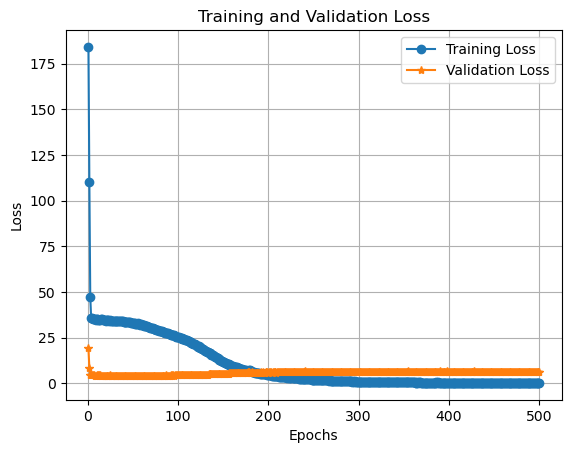

In [242]:
plot_loss(t_loss_list, v_loss_list)

In [243]:
best_model = CpGPredictor()
best_model.load_state_dict(best_model_state_dict)

<All keys matched successfully>

In [247]:
def evaluate_model(model):
    # eval (you can modify the code below)
    model.eval()

    res_gt = []
    res_pred = []

    test_loss = 0
    for batch in test_data_loader:
        # TODO complete inference loop
        inputs, labels = batch

        inputs = inputs.float()
        labels = labels.float()

        y_pred = model(inputs)

        res_gt.extend(labels.tolist())
        res_pred.extend(y_pred.tolist())

        # test_loss += loss_fn(y_pred, labels)

        # Extra lines of code for Gaussian
        labels_unsq = labels.unsqueeze(1)
        var = torch.ones(labels_unsq.shape[0], labels_unsq.shape[1], requires_grad=True)
        y_pred_unsq = y_pred.unsqueeze(1)
        test_loss += loss_fn(y_pred_unsq, labels_unsq, var).item()

    return test_loss, res_gt, res_pred

In [248]:
def compute_metrics(res_gt, res_pred):
    # NOTE: We can have additional metrics such as MAE etc;  
    # Rounding might not be needed, depends on usecase!
    res_pred_rounded = [float(round(res)) for res in res_pred]

    accuracy = accuracy_score(res_gt, res_pred_rounded)
    precision = precision_score(res_gt, res_pred_rounded, average='macro', zero_division=0)
    recall = recall_score(res_gt, res_pred_rounded, average='macro', zero_division=0)

    return accuracy, precision, recall

In [249]:
best_model_test_loss, best_model_res_gt, best_model_res_pred = evaluate_model(best_model)
# This is not needed as we are using validation data to get best model!
# last_model_test_loss, last_model_res_gt, last_model_res_pred = evaluate_model(model)

In [250]:
best_acc, best_pre, best_rec = compute_metrics(best_model_res_gt, best_model_res_pred)
best_model_test_loss, best_acc, best_pre, best_rec

(8.975246906280518, 0.197265625, 0.03726988823142669, 0.08436213991769548)

In [92]:
# last_model_acc, last_model_pre, last_model_rec = compute_metrics(last_model_res_gt, last_model_res_pred)
# last_model_test_loss, last_model_acc, last_model_pre, last_model_rec

In [93]:
torch.save(best_model.state_dict(), "trial_model_part1.pkl")

Web Application - Work in progress!

In [94]:
import streamlit as st

model.load_state_dict(torch.load('trial_model.pkl'))
model.eval()

# Define function to predict CpG sites
def predict_cpg(sequence):
    encoded_seq = map(dnaseq_to_intseq, sequence)
    print(encoded_seq)
    with torch.no_grad():
        pred = model(encoded_seq.unsqueeze(0))  
    return int(pred.item())

# Streamlit app
st.title('CpG Site Predictor')

# Input box
sequence_input = st.text_input('Enter DNA sequence (e.g., "NACGT")')

# Prediction
if sequence_input:
    prediction = predict_cpg(sequence_input)
    st.write(f'Predicted CpG sites: {prediction}')

2024-03-15 15:11:22.399 
  command:

    streamlit run /hdd4/srinath2/.conda/envs/llm_env/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]


# Part 2: what if the DNA sequences are not the same length

Work in progress - If the metrics for 1st part becomes better, this is straight-forward, filled out all the TODOs, so it's a standard training loop and reformatting the code a bit!

In [142]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [143]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers   
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [144]:
# TODO complete the task based on the change
def pad_sequence(sequence: Sequence[int], max_len: int) -> Sequence[int]:
    padded_sequence = sequence[:max_len] + [0] * (max_len - len(sequence))
    return padded_sequence

def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step 2. Pad all the examples with max length!
    X_dna_seqs_train_padded = [pad_sequence(seq, max_len) for seq in X_dna_seqs_train]
    
    temp = list(map(''.join, map(intseq_to_dnaseq, X_dna_seqs_train_padded)))
    #step3
    y_dna_seqs = [count_cpgs(seq) for seq in temp]
    
    return X_dna_seqs_train, y_dna_seqs

    
min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
valid_x, valid_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [145]:
# Quick check to confirm the changes i.e different examples should have different lengths!
# train_x[:1], train_y[:1]
eg = list(map(''.join, map(intseq_to_dnaseq, train_x[:10])))
eg0, eg1 = eg[0], eg[1]
print(len(eg0), len(eg1))

97 107


In [172]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)

    
# this will be a collate_fn for dataloader to pad sequence  
class PadSequence:
    #TODO
    def __init__(self, padding_value=0):
        self.padding_value = padding_value
    
    def __call__(self, batch):
        # Sort the batch by sequence length
        batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
        # Separate sequences and labels
        sequences, labels = zip(*batch)
        # Pad sequences
        # 1. either use the max of batch length 
        # 2. Or a constant for eg: 128. 
        # Using the max-batch will result in batches with different lengths i.e [32, 108], [32, 126] etc; 
        # max_length = max(len(seq) for seq in sequences)

        max_length = 128
        # Tried using pad_sequence but it throws an unexpected error. 
        # Can use the other functions but for timebeing, this serves the purpose 
        padded_sequences = []
        for seq in sequences:
            pad_length = max_length - len(seq)
            # print(pad_length)
            pad_tensor = torch.full((pad_length,), self.padding_value, dtype=torch.long)
            # print(pad_tensor)
            padded_seq = torch.cat((seq, pad_tensor), dim=0)
            # padded_seq = seq + [self.padding_value] * pad_length
            padded_sequences.append(padded_seq)
        # Convert to tensor
        padded_sequences = torch.stack(padded_sequences, dim=0)
        labels_tensor = torch.tensor(labels, dtype=torch.long)
        return padded_sequences, labels_tensor

In [173]:
# TODO complete the rest
train_dataset = MyDataset(train_x, train_y)
valid_dataset = MyDataset(valid_x, valid_y)
test_dataset = MyDataset(test_x, test_y)

In [174]:
batch_size = 32

In [175]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=PadSequence())
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=PadSequence())

In [ ]:
# init model / loss function / optimizer etc.
model = CpGPredictor()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_model_state_dict, t_loss_list, v_loss_list = train()

In [ ]:
plot_loss(t_loss_list, v_loss_list)

In [ ]:
best_model = CpGPredictor()
best_model.load_state_dict(best_model_state_dict)

In [ ]:
best_model_test_loss, best_model_res_gt, best_model_res_pred = evaluate_model(best_model)
best_acc, best_pre, best_rec = compute_metrics(best_model_res_gt, best_model_res_pred)
best_model_test_loss, best_acc, best_pre, best_rec

In [ ]:
torch.save(best_model.state_dict(), "trial_model_part2.pkl")

TODO: App building for this model as well! I believe it's just a function call!